<a href="https://colab.research.google.com/github/Mr-houngbo/respire/blob/main/prediction/prediction_polluants_esmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

In [2]:
!pip install -q gdown
import gdown

lien = "https://drive.google.com/file/d//view?usp=sharing"


# ID du Dataset
file_id = "1b4sKColUCmG2LhQO54tRA2_okXiTvR8I"
url = f"https://drive.google.com/uc?id={file_id}"
output = "164928.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1b4sKColUCmG2LhQO54tRA2_okXiTvR8I
To: /content/164928.csv
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 3.62k/3.62k [00:00<00:00, 10.1MB/s]


'164928.csv'

In [3]:
esmt = pd.read_csv("164928.csv")

In [4]:
esmt.head()

Location ID Location Name  Location Group Location Type  \
0       164928   Breath4life             NaN       Outdoor   
1       164928   Breath4life             NaN       Outdoor   
2       164928   Breath4life             NaN       Outdoor   
3       164928   Breath4life             NaN       Outdoor   
4       164928   Breath4life             NaN       Outdoor   

                  Sensor ID  Place Open      Local Date/Time  \
0  airgradient:d83bda1d43d8        True  2025-08-08 00:00:00   
1  airgradient:d83bda1d43d8        True  2025-08-07 00:00:00   
2  airgradient:d83bda1d43d8        True  2025-08-06 00:00:00   
3  airgradient:d83bda1d43d8        True  2025-08-05 00:00:00   
4  airgradient:d83bda1d43d8        True  2025-08-04 00:00:00   

              UTC Date/Time  # of aggregated records  PM2.5 (Î¼g/mÂ³) raw  ...  \
0  2025-08-08T00:00:00.000Z                     1173               15.4  ...   
1  2025-08-07T00:00:00.000Z                     1315                7.9  ...   
2  2025-08-06T00:00:00.000Z                     1348                8.3  ...   
3  2025-08-05T00:00:00.000Z                     1312               14.2  ...   
4  2025-08-04T00:00:00.000Z                     1252               13.5  ...   

   Temperature (Â°C) raw  Temperature (Â°C) corrected  Heat Index (Â°C)  \
0                  29.9                        30.2             37.6   
1                  30.3                        30.6             38.9   
2                  31.0                        31.5             40.7   
3                  29.8                        30.1             37.5   
4                  30.2                        30.6             37.5   

   Humidity (%) raw  Humidity (%) corrected  TVOC (ppb)  TVOC index  \
0                56                      78         123         120   
1                57                      79          89          91   
2                54                      76         121         115   
3                56                      78         133         123   
4                53                      74         143         135   

   NOX index  PM1 (Î¼g/mÂ³)  PM10 (Î¼g/mÂ³)  
0          1          5.6          18.1  
1          1          2.7           9.4  
2          1          3.7           9.3  
3          1          6.1          16.2  
4          1          6.0          15.2  

[5 rows x 24 columns]

In [5]:
esmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Location ID                 18 non-null     int64  
 1   Location Name               18 non-null     object 
 2   Location Group              0 non-null      float64
 3   Location Type               18 non-null     object 
 4   Sensor ID                   18 non-null     object 
 5   Place Open                  18 non-null     bool   
 6   Local Date/Time             18 non-null     object 
 7   UTC Date/Time               18 non-null     object 
 8   # of aggregated records     18 non-null     int64  
 9   PM2.5 (Î¼g/mÂ³) raw           18 non-null     float64
 10  PM2.5 (Î¼g/mÂ³) corrected     18 non-null     float64
 11  0.3Î¼m particle count        18 non-null     int64  
 12  CO2 (ppm) raw               18 non-null     int64  
 13  CO2 (ppm) corrected         18 n

In [ ]:
esmt.shape

(18, 24)

In [ ]:
df = esmt.copy()

In [ ]:
df.isnull().sum()

Location ID                    0
Location Name                  0
Location Group                18
Location Type                  0
Sensor ID                      0
Place Open                     0
Local Date/Time                0
UTC Date/Time                  0
# of aggregated records        0
PM2.5 (Î¼g/mÂ³) raw              0
PM2.5 (Î¼g/mÂ³) corrected        0
0.3Î¼m particle count           0
CO2 (ppm) raw                  0
CO2 (ppm) corrected            0
Temperature (Â°C) raw           0
Temperature (Â°C) corrected     0
Heat Index (Â°C)                0
Humidity (%) raw               0
Humidity (%) corrected         0
TVOC (ppb)                     0
TVOC index                     0
NOX index                      0
PM1 (Î¼g/mÂ³)                    0
PM10 (Î¼g/mÂ³)                   0
dtype: int64

In [ ]:
# Supprimer colonnes inutiles
cols_a_supprimer = [
    'Location ID', 'Location Name', 'Location Group', 'Location Type',
    'Sensor ID', 'Place Open', 'UTC Date/Time','# of aggregated records'] + [col for col in df.columns if "raw" in col.lower()]  # remove raw

df.drop(columns=cols_a_supprimer, inplace=True, errors='ignore')

In [ ]:
df.isnull().sum()

Local Date/Time               0
PM2.5 (Î¼g/mÂ³) corrected       0
0.3Î¼m particle count          0
CO2 (ppm) corrected           0
Temperature (Â°C) corrected    0
Heat Index (Â°C)               0
Humidity (%) corrected        0
TVOC (ppb)                    0
TVOC index                    0
NOX index                     0
PM1 (Î¼g/mÂ³)                   0
PM10 (Î¼g/mÂ³)                  0
dtype: int64

In [ ]:
df.shape

(18, 12)

In [ ]:
num_cols = df.select_dtypes(include = ["number"]).columns
cat_cols = df.select_dtypes(include = ["object"]).columns

In [ ]:
# Convertir la date en datetime + tri
df['Local Date/Time'] = pd.to_datetime(df['Local Date/Time'])
df.sort_values('Local Date/Time', inplace=True)
df.set_index('Local Date/Time', inplace=True)

In [ ]:
df.head()

PM2.5 (Î¼g/mÂ³) corrected  0.3Î¼m particle count  \
Local Date/Time                                                  
2025-07-18                          10.5                   481   
2025-07-22                          24.4                   740   
2025-07-24                           6.7                   371   
2025-07-25                           4.8                   310   
2025-07-26                           5.4                   349   

                 CO2 (ppm) corrected  Temperature (Â°C) corrected  \
Local Date/Time                                                    
2025-07-18                       654                        32.5   
2025-07-22                       505                        33.0   
2025-07-24                       400                        27.2   
2025-07-25                       396                        28.4   
2025-07-26                       395                        30.3   

                 Heat Index (Â°C)  Humidity (%) corrected  TVOC (ppb)  \
Local Date/Time                                                        
2025-07-18                  46.7                      81          96   
2025-07-22                  45.9                      75          95   
2025-07-24                  29.5                      77          67   
2025-07-25                  31.7                      73          94   
2025-07-26                  35.4                      69         113   

                 TVOC index  NOX index  PM1 (Î¼g/mÂ³)  PM10 (Î¼g/mÂ³)  
Local Date/Time                                                    
2025-07-18              102          1          4.5          12.3  
2025-07-22              101          1          9.3          26.5  
2025-07-24               69          1          2.3           7.7  
2025-07-25               94          1          1.5           5.6  
2025-07-26              110          2          2.2           6.3

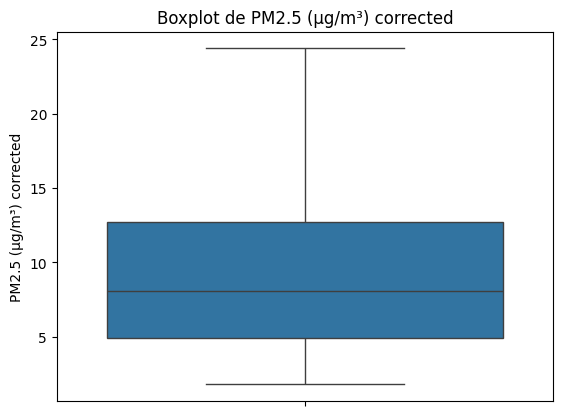

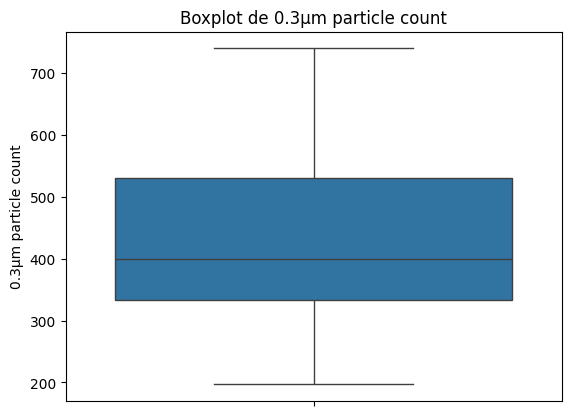

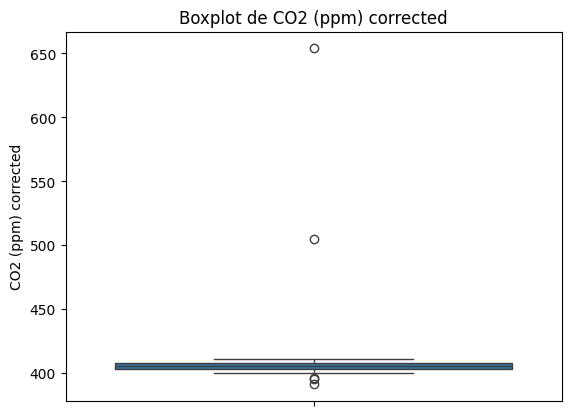

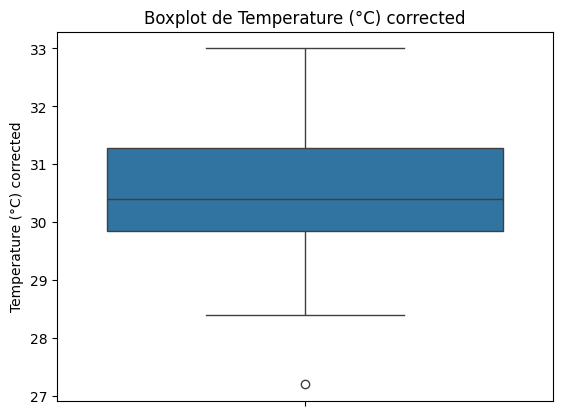

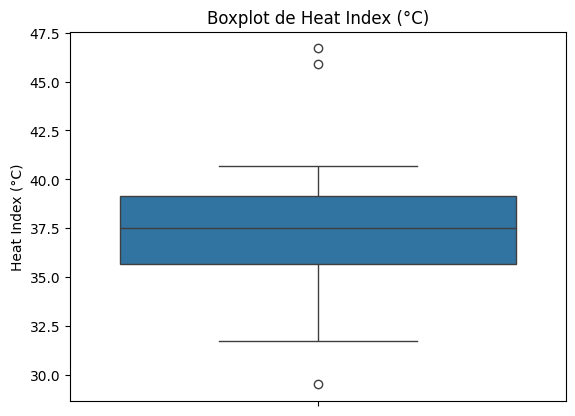

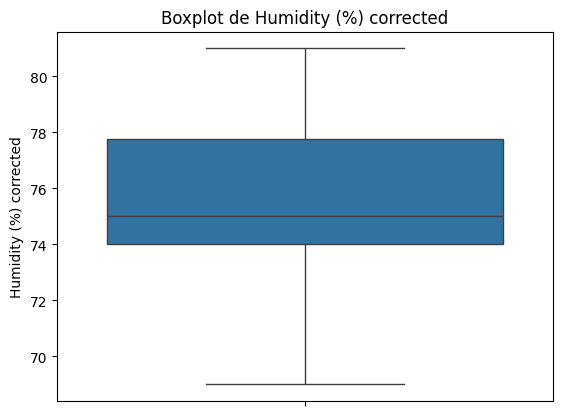

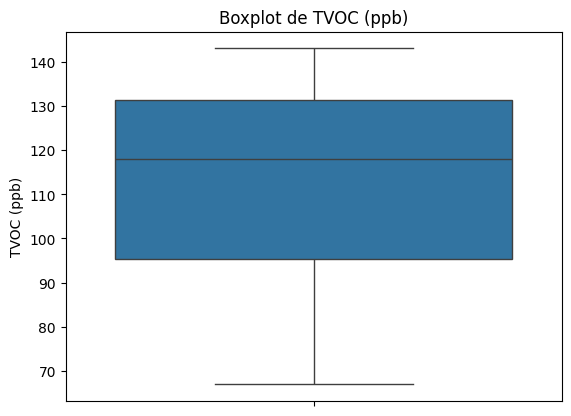

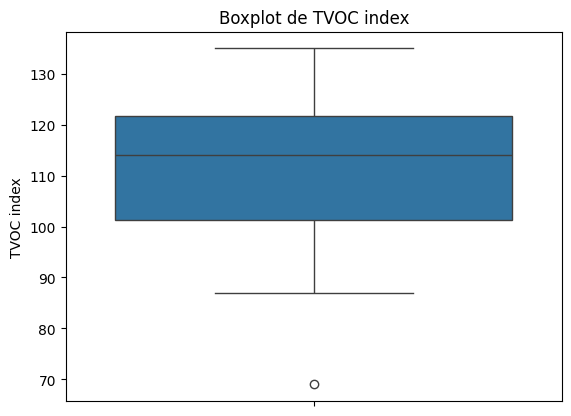

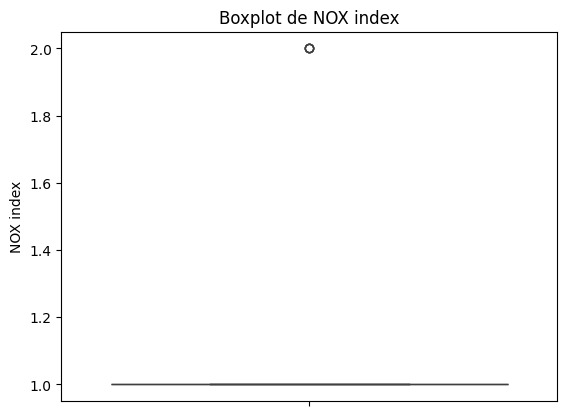

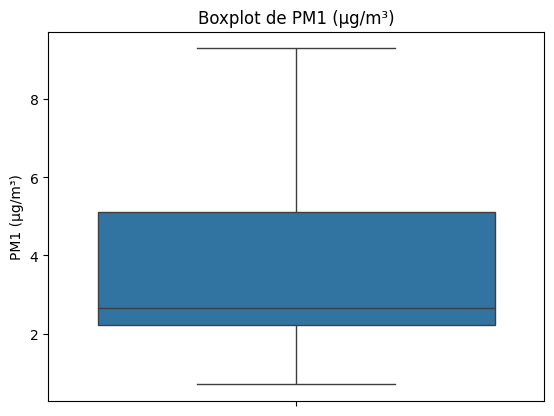

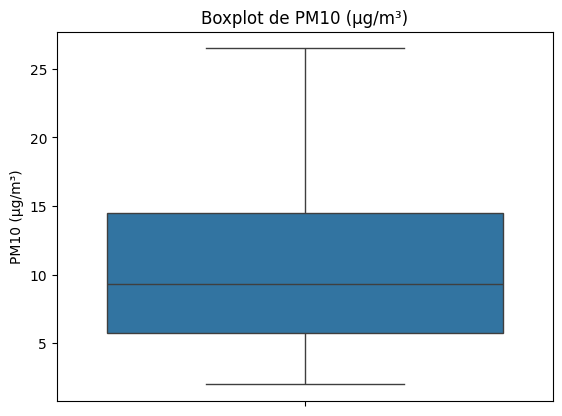

In [ ]:
for col in num_cols:
    sns.boxplot(df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [ ]:
# === 2. FenÃªtrage glissant pour J+1 ===
def create_lag_features(data, target_col, lags=7):
    df_feat = pd.DataFrame(index=data.index)
    for lag in range(1, lags+1):
        df_feat[f"{target_col}_lag{lag}"] = data[target_col].shift(lag)
    df_feat['target'] = data[target_col].shift(-1)  # prÃ©dire J+1
    return df_feat.dropna()


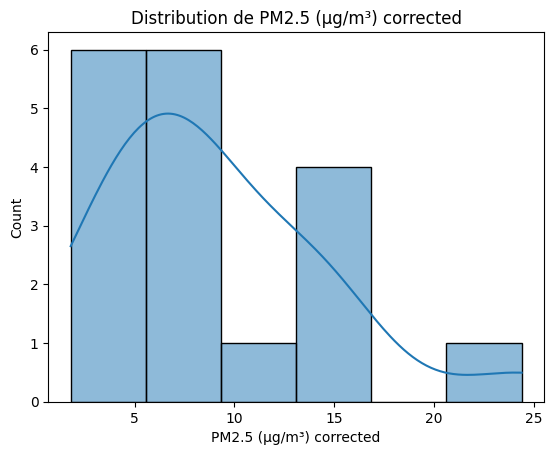

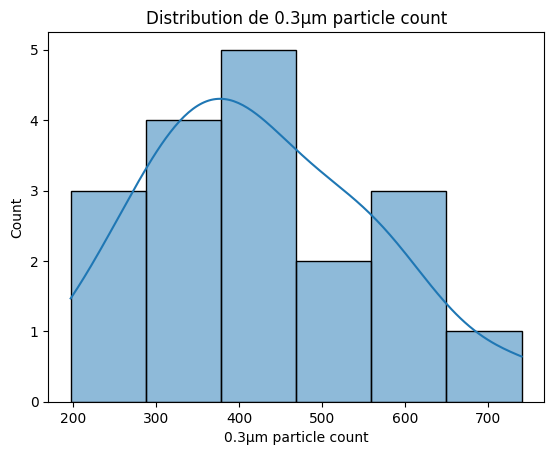

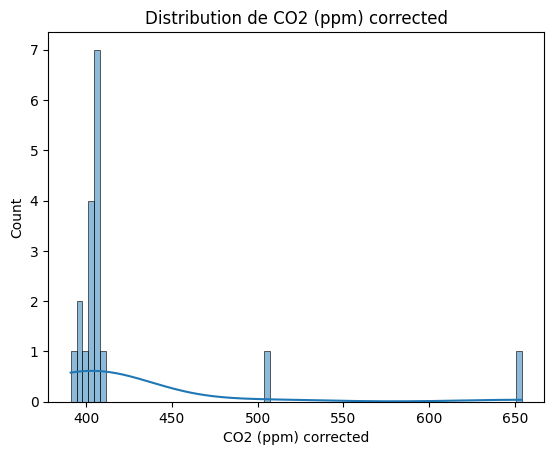

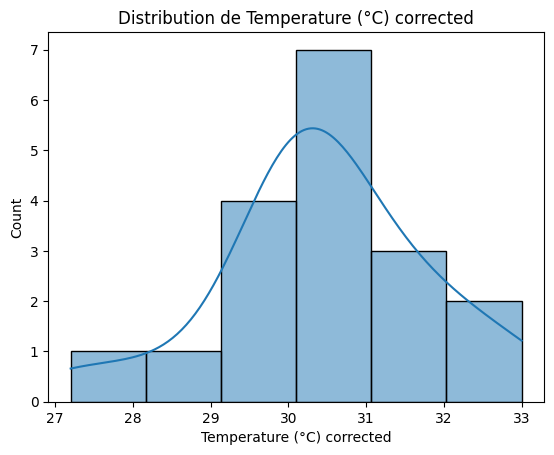

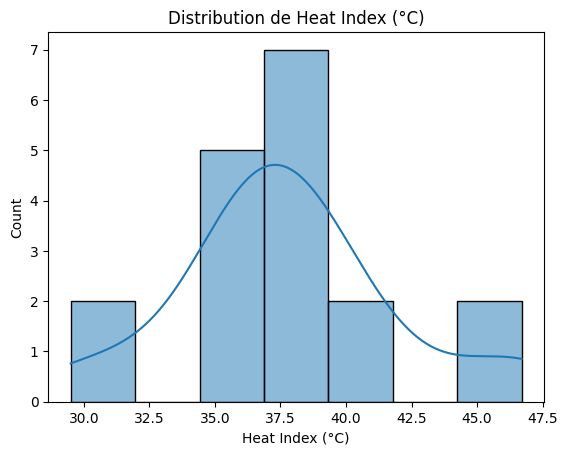

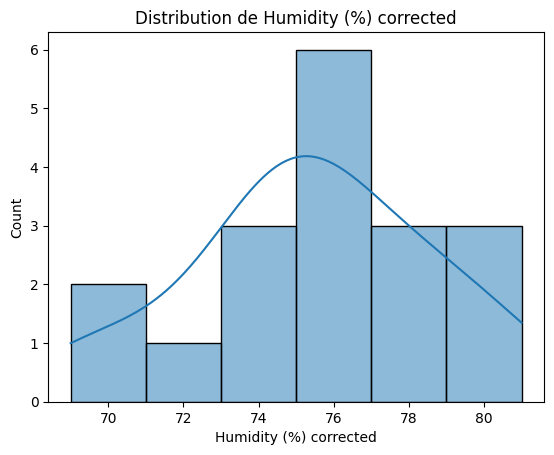

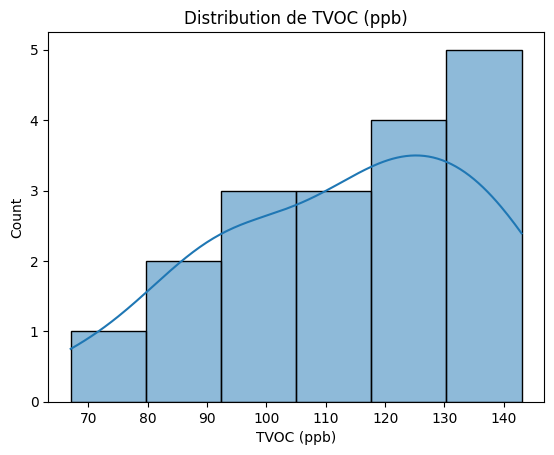

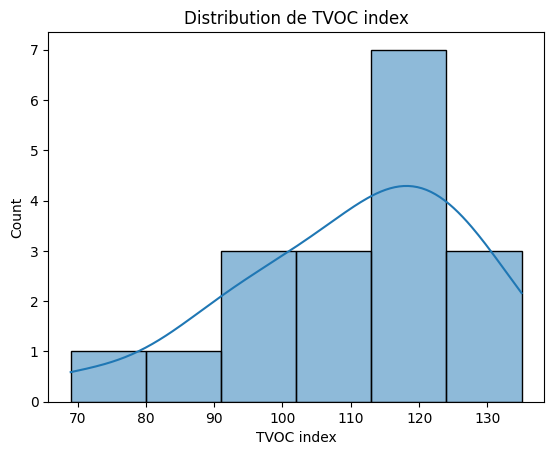

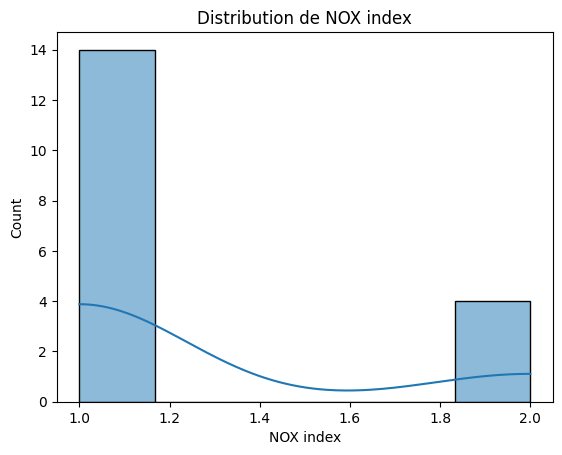

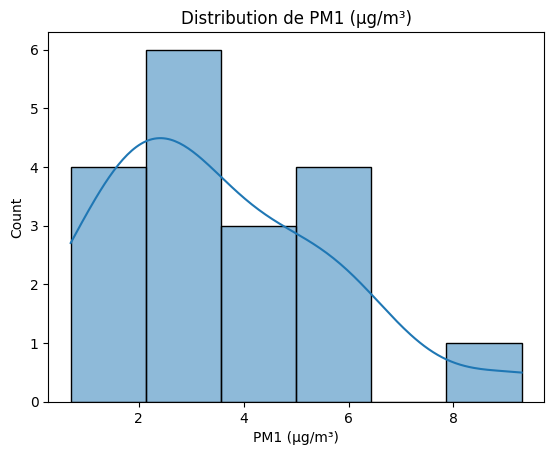

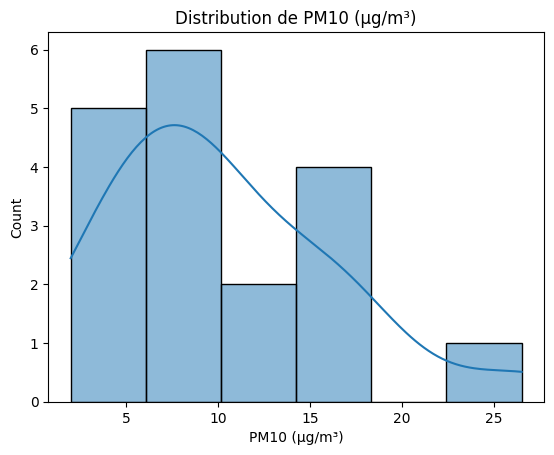

In [ ]:
for col in num_cols:
    sns.histplot(df[col],kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()

<Axes: >

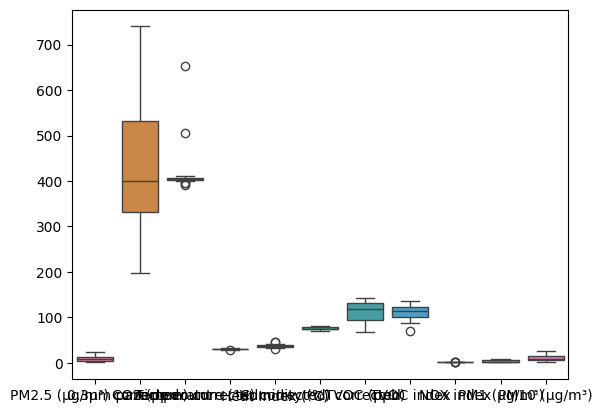

In [ ]:
sns.boxplot(df)

<Axes: >

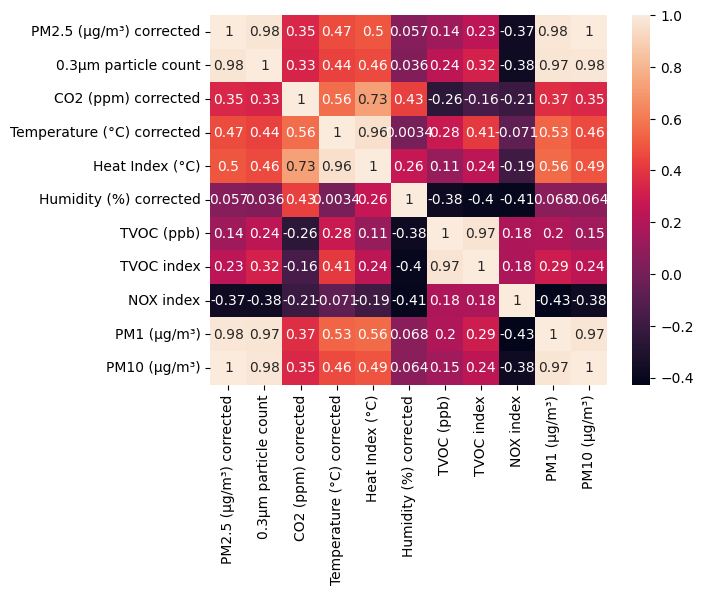

In [ ]:
sns.heatmap(df.corr(),annot=True)

In [ ]:
# ==== 1. Imports ====
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import joblib


# ==== 2. Fonction de transformation en problÃ¨me supervisÃ© ====
def create_supervised(df, n_lags=1):
    """
    Transforme un DataFrame en jeu de donnÃ©es supervisÃ© avec dÃ©calages temporels.

    Args:
        df (pd.DataFrame): Jeu de donnÃ©es original, indexÃ© par date.
        n_lags (int): Nombre de jours en mÃ©moire (features dÃ©calÃ©es).

    Returns:
        pd.DataFrame: Jeu de donnÃ©es supervisÃ© avec colonnes t-1, t-2, ..., t et sans NaN.
    """
    df_supervised = pd.DataFrame()

    # Ajout des dÃ©calages (features passÃ©es)
    for i in range(n_lags, 0, -1):
        shifted = df.shift(i)
        shifted.columns = [f"{col}(t-{i})" for col in df.columns]
        df_supervised = pd.concat([df_supervised, shifted], axis=1)

    # Ajout des valeurs cibles (temps prÃ©sent)
    df_supervised = pd.concat([df_supervised, df], axis=1)

    # Suppression des lignes avec NaN
    df_supervised.dropna(inplace=True)
    return df_supervised


# ==== 3. ParamÃ¨tres ====
n_lags = 3  # Nombre de jours utilisÃ©s pour prÃ©dire J+1
df = esmt.copy()  # Exemple : chargement dataset

# Supprimer colonnes inutiles
cols_a_supprimer = [
    'Location ID', 'Location Name', 'Location Group', 'Location Type',
    'Sensor ID', 'Place Open', 'UTC Date/Time','# of aggregated records'] + [col for col in df.columns if "raw" in col.lower()]  # remove raw

df.drop(columns=cols_a_supprimer, inplace=True, errors='ignore')

# Convertir la date en datetime + tri
df['Local Date/Time'] = pd.to_datetime(df['Local Date/Time'])
df.sort_values('Local Date/Time', inplace=True)
df.set_index('Local Date/Time', inplace=True)


# CrÃ©ation des donnÃ©es supervisÃ©es
data_supervised = create_supervised(df, n_lags=n_lags)


# ==== 4. Split Train/Test ====
train_size = int(len(data_supervised) * 0.8)
train, test = data_supervised.iloc[:train_size], data_supervised.iloc[train_size:]

# SÃ©paration Features / Targets
X_train, y_train = train.iloc[:, :-len(df.columns)], train.iloc[:, -len(df.columns):]
X_test, y_test = test.iloc[:, :-len(df.columns)], test.iloc[:, -len(df.columns):]


# ==== 5. Normalisation ====
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)



# ====  DÃ©finition du modÃ¨le de base ====
base_model = XGBRegressor(random_state=42)

# MultiOutput wrapper
multi_output_model = MultiOutputRegressor(base_model)

# ==== . Grille d'hyperparamÃ¨tres ====
param_grid = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__max_depth": [3, 5, 7],
    "estimator__subsample": [0.8, 1.0],
    "estimator__colsample_bytree": [0.8, 1.0]
}

# ==== . Cross Validation + Grid Search ====
grid_search = GridSearchCV(
    estimator=multi_output_model,
    param_grid=param_grid,
    cv=5,  # nombre de folds
    scoring='r2',  # ou 'neg_mean_squared_error'
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train_scaled)

# ==== . RÃ©sultats ====
print("Meilleurs paramÃ¨tres :", grid_search.best_params_)
print("Score CV (meilleur) :", grid_search.best_score_)

# ==== . Utilisation du meilleur modÃ¨le ====
model = grid_search.best_estimator_

# RÃ©entraÃ®nement sur tout le jeu d'entraÃ®nement
model.fit(X_train_scaled, y_train_scaled)



# ==== 7. PrÃ©diction et mÃ©triques ====
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

results = {"RMSE": rmse, "MAE": mae, "R2": r2}
print("ðŸ“Š Performance du modÃ¨le :", results)


# ==== 8. Sauvegarde du modÃ¨le et paramÃ¨tres ====
joblib.dump(model, "xgboost_multioutput.pkl")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")
joblib.dump(df.columns.tolist(), "target_columns.pkl")  # Sauvegarde des noms de colonnes cibles
joblib.dump(n_lags, "n_lags.pkl")  # Sauvegarde du nombre de lags
print("âœ… ModÃ¨le, scalers, colonnes et paramÃ¨tres sauvegardÃ©s !")


# ==== 9. Fonction de prÃ©diction J+1 ====
def predict_j_plus_1(last_days_df, model_path="xgboost_multioutput.pkl"):
    """
    PrÃ©dit les valeurs du jour suivant Ã  partir des n_lags derniers jours.

    Args:
        last_days_df (pd.DataFrame): Les n_lags derniers jours d'historique (index = dates).
        model_path (str): Chemin vers le modÃ¨le sauvegardÃ©.

    Returns:
        pd.DataFrame: Valeurs prÃ©dites pour J+1.
    """
    # Chargement du modÃ¨le et des paramÃ¨tres
    model = joblib.load(model_path)
    scaler_X = joblib.load("scaler_X.pkl")
    scaler_y = joblib.load("scaler_y.pkl")
    target_columns = joblib.load("target_columns.pkl")
    n_lags = joblib.load("n_lags.pkl")

    # VÃ©rification du nombre de jours d'historique
    if len(last_days_df) != n_lags:
        raise ValueError(f"Il faut exactement {n_lags} jours d'historique pour prÃ©dire.")

         # Construction des features pour la prÃ©diction
    features = []
    for i in range(n_lags, 0, -1):
        features.extend(last_days_df.iloc[-i].values)

    # Reformater en DataFrame avec les bons noms
    feature_names = []
    for i in range(n_lags, 0, -1):
        feature_names.extend([f"{col}(t-{i})" for col in target_columns])

    features_df = pd.DataFrame([features], columns=feature_names)

    # Scaling et prÃ©diction
    features_scaled = scaler_X.transform(features_df)
    pred_scaled = model.predict(features_scaled)
    pred = scaler_y.inverse_transform(pred_scaled)


    # Retour sous forme de DataFrame
    return pd.DataFrame(
        pred,
        columns=target_columns,
        index=[last_days_df.index[-1] + pd.Timedelta(days=1)]
    )


# ==== 10. Exemple d'utilisation ====
dernier_jours = df.tail(n_lags)
print("ðŸ”® PrÃ©diction J+1 :")
print(predict_j_plus_1(dernier_jours))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramÃ¨tres : {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 7, 'estimator__n_estimators': 300, 'estimator__subsample': 0.8}
Score CV (meilleur) : -68.2182194357856
ðŸ“Š Performance du modÃ¨le : {'RMSE': np.float64(33.872817597304255), 'MAE': 14.45130575208953, 'R2': -2.15188471169397}
âœ… ModÃ¨le, scalers, colonnes et paramÃ¨tres sauvegardÃ©s !
ðŸ”® PrÃ©diction J+1 :
            PM2.5 (Î¼g/mÂ³) corrected  0.3Î¼m particle count  \
2025-08-09                12.664956            554.870605   

            CO2 (ppm) corrected  Temperature (Â°C) corrected  Heat Index (Â°C)  \
2025-08-09           403.189789                   29.469826        36.047474   

            Humidity (%) corrected  TVOC (ppb)  TVOC index  NOX index  \
2025-08-09               71.930626  115.272095  115.322655   1.000904   

            PM1 (Î¼g/mÂ³)  PM10 (Î¼g/mÂ³)  
2025-08-09     4.998051     